Run locally or <a target="_blank" href="https://colab.research.google.com/github/aalgahmi/dl_handouts/blob/main/17.generative_deep_learning-part_1.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
%%capture
!pip install -q torchinfo torchviz lightning opendatasets

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Generative Deep Learning - Part 1

This notebook focuses on two generative deep learning models: Variational Autoencoders (VAEs) and Generative Adversarial Networks (GANs).

### Variational autoencoders (VAEs)

Unlike the previous autoencoders we've seen, a variational autoencoder (VAE) is a generative model. This means that it has the ability to generate new data instances (images, for instance). Like traditional autoencoders, variational autoencoders (VAEs) consist of an encoder and a decoder. However, VAEs aim to learn a probability distribution over possible latent representations (codings), typically Gaussian. They do so by simultaneously minimizing two losses:
* reconstruction loss, and
* regularization loss: the Kullback-Leibler (KL) divergence.

The learned probability distribution can then be sampled and used to generate new data points. Here is how variational autoencoders work.

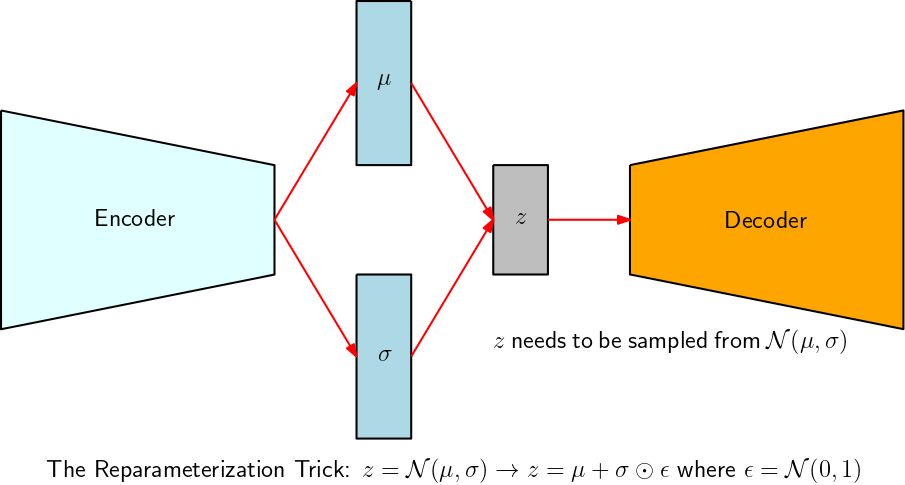

As we learned in the lecture, the encoder produces two codings: $\mathbf \mu$ and $\mathbf \sigma$. These codings are used to sample a new latent vector $\mathbf z$, which serves as input to the decoder. However, because the sampling operation is not differentiable, it prevents the model from backpropagating gradients, which is necessary for training. To address this issue, the **reparametrization trick** is used. This trick involves introducing a new variable $\epsilon$ that is sampled from a simple standard normal distribution and then transforming it into a sample from the learned Gaussian distribution using the mean and standard deviation parameters learned by the encoder. More precisely, instead of directly having:

$$ \mathbf z = \mathcal{N}(\mathbf \mu, \mathbf \sigma)$$

we instead have:

$$ \mathbf z = \mathbf \mu + \mathbf \sigma * \epsilon = \mathbf \mu + e^{\gamma / 2} * \epsilon $$

where $\epsilon \sim \mathcal{N}(0,1)$.

To further improve the numerical stability of VAEs, the **log-var trick** can also be used. This requires the encoder to produce the coding $\mathbf \gamma = \log(\mathbf \sigma^2)$ instead of directly outputting $\mathbf \sigma$. With this trick, the **reparametrization trick** is modified as follows:

$$ \mathbf z = \mathbf \mu + \mathbf \sigma * \epsilon = \mathbf \mu + e^{\gamma / 2} * \epsilon $$

In this section, we will implement a simple variational autoencoder and train it using the MNIST dataset. To start, we load and split the data:

In [3]:
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader

data_path='./datasets'

ds_train, ds_val = random_split(
    datasets.MNIST(data_path, train=True, download=True, transform=transforms.ToTensor()),
    [.6, .4])

dl_train = DataLoader(ds_train, batch_size=32, shuffle=True, num_workers=2)

len(dl_train)

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 480kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.41MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.18MB/s]


1125

Next we build a simple model. This model will implement both the reparametrization and the log-var tricks.

In [4]:
class VAE(nn.Module):
    def __init__(self, img_size, codings_size=16):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(img_size, 512),
            nn.ReLU()
        )

        # Mean and log_var (We are using the log-var trick)
        self.mean = nn.Linear(512, codings_size)
        self.log_var = nn.Linear(512, codings_size)

        self.decoder = nn.Sequential(
            nn.Linear(codings_size, 512),
            nn.ReLU(),
            nn.Linear(512, img_size),
            nn.Sigmoid(),
            nn.Unflatten(1, (1, 28, 28))
        )

    def reparameterize(self, mu, gamma):
        sigma = torch.exp(.5 * gamma)
        epsilon = torch.randn_like(sigma)
        z = mu + sigma * epsilon

        return z

    def forward(self, x):
        x = self.encoder(x)
        mean, log_var = self.mean(x), self.log_var(x)

        z = self.reparameterize(mean, log_var)
        x_hat = self.decoder(z)

        return x_hat, (x, mean, log_var)

vae = VAE(img_size=784)

Let's summarize this model:

In [5]:
from torchinfo import summary

summary(vae, input_size=(1, 1, 28, 28), device="cpu")

Layer (type:depth-idx)                   Output Shape              Param #
VAE                                      [1, 1, 28, 28]            --
├─Sequential: 1-1                        [1, 512]                  --
│    └─Flatten: 2-1                      [1, 784]                  --
│    └─Linear: 2-2                       [1, 512]                  401,920
│    └─ReLU: 2-3                         [1, 512]                  --
├─Linear: 1-2                            [1, 16]                   8,208
├─Linear: 1-3                            [1, 16]                   8,208
├─Sequential: 1-4                        [1, 1, 28, 28]            --
│    └─Linear: 2-4                       [1, 512]                  8,704
│    └─ReLU: 2-5                         [1, 512]                  --
│    └─Linear: 2-6                       [1, 784]                  402,192
│    └─Sigmoid: 2-7                      [1, 784]                  --
│    └─Unflatten: 2-8                    [1, 1, 28, 28]           

To train this we need to specify both the loss and the optimizer. The optimizer is simple; let's use Adam.

In [6]:
optimizer = torch.optim.Adam(vae.parameters(), lr=0.001)

For the loss, we combine two types of losses:

1. **Reconstruction Loss**: This loss aids the model in improving its ability to reconstruct input images. When assuming a standard normal distribution, the reconstruction loss is simply the regular L2 loss, given by:

$$ \sum_{i=1}^n (y - \hat{y})^2 $$

2. **Regularization Loss (Latent Loss)**: Typically, this is the Kullback-Leibler (KL) divergence between the learned approximate posterior distribution and the prior distribution of the latent variable $\mathbf{z}$. The regularization loss serves to prevent overfitting, ensure a well-structured latent space, and encourage the learned approximate posterior distribution to closely match a predefined prior distribution. This prior distribution is often a standard normal distribution with a mean of 0 and a standard deviation of 1.

Mathematically, the regularization loss is expressed as:

$$ \text{KL}(q(\mathbf{z} | \mathbf{x}) || p(\mathbf{z})) = -\frac{1}{2} \sum_{i=1}^{n} (1 + \log(\sigma_i^2) - \sigma_i^2 - \mu_i^2) $$

Where $ \mu_i $ and $ \sigma_i^2 $ represent the mean and variance of the approximate posterior distribution for the \( i \)-th latent variable. Utilizing the log-var trick, this can be rewritten as:

$$ \text{KL}(q(\mathbf{z} | \mathbf{x}) || p(\mathbf{z})) = - \frac{1}{2} \sum_{i=1}^n (1 + \gamma_i - \exp(\gamma_i) - \mu^2) $$

Where $ \mathbf \gamma_i = \log(\mathbf \sigma_i^2) $.

Here is a function that implements and combines both losses:

In [7]:
def loss_fn(x_hat, x, mu, gamma):
    reconstruction_loss = F.mse_loss(x_hat, x, reduction="sum") # ((x - x_hat)**2).sum()
    regularization_loss = -0.5 * torch.sum(1 + gamma - gamma.exp() - mu.pow(2))

    return reconstruction_loss + regularization_loss

We are now ready to train this model:

In [8]:
def train(model, loss_fn, optimizer, dl_train, epochs=10):
    losses = []

    for epoch in range(epochs):
        batch_losses = 0.0
        for x_batch, _ in dl_train:
            reconstructed_x, (encoded_x, mean, log_var) = model(x_batch)

            loss = loss_fn(reconstructed_x, x_batch, mean, log_var)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batch_losses += loss.item() * x_batch.size(0)

        epoch_loss = batch_losses / len(dl_train)
        losses.append(epoch_loss)

        if epochs // 10 < 5 or (epoch == 0 or (epoch + 1) % 10 == 0):
            print(f"Epoch{epoch + 1: 3d}/{epochs}: loss={epoch_loss:.4f}")

    return losses

losses = train(vae, loss_fn, optimizer, dl_train)

Epoch  1/10: loss=41419.6294
Epoch  2/10: loss=34437.3212
Epoch  3/10: loss=33289.4904
Epoch  4/10: loss=32725.4307
Epoch  5/10: loss=32357.1088
Epoch  6/10: loss=32126.1425
Epoch  7/10: loss=31879.3312
Epoch  8/10: loss=31698.7073
Epoch  9/10: loss=31523.1781
Epoch 10/10: loss=31417.6846


Plotting the losses shows how training went:

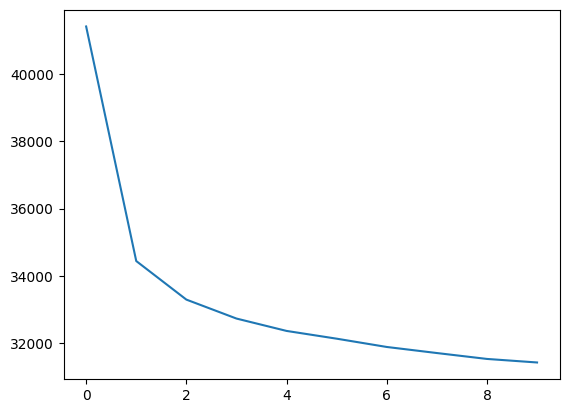

In [9]:
plt.plot(losses)

To check how good (or bad) this model is, let's plot a few original validation images (row 1) alongside their reconstructions (row 2).

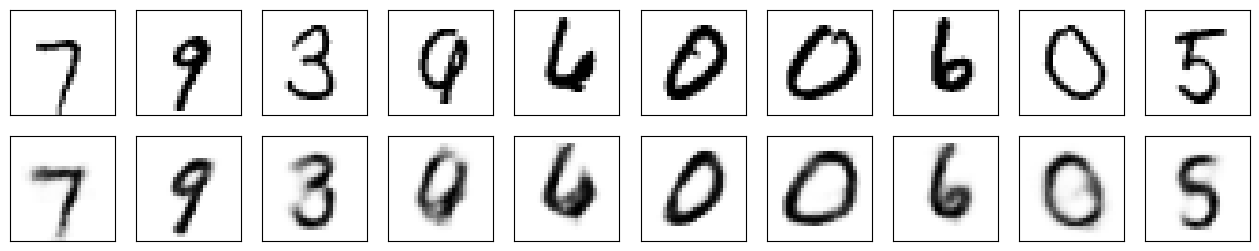

In [10]:
X_val = torch.stack([x for x, _ in ds_val])

original_images  = X_val[:10]

reconstructions, _= vae(original_images)
reconstructed_images = torch.clip(reconstructions.detach(), 0, 1)

fig = plt.figure(figsize=(16, 3))
for i in range(10):
    plt.subplot(2, 10, i + 1)
    plt.imshow(original_images[i].squeeze(), cmap="binary")
    plt.xticks([])
    plt.yticks([])

    plt.subplot(2, 10, i + 11)
    plt.imshow(reconstructed_images[i].squeeze(), cmap="binary")
    plt.xticks([])
    plt.yticks([])

plt.show()

Being a generative model, let's generate a few new images.

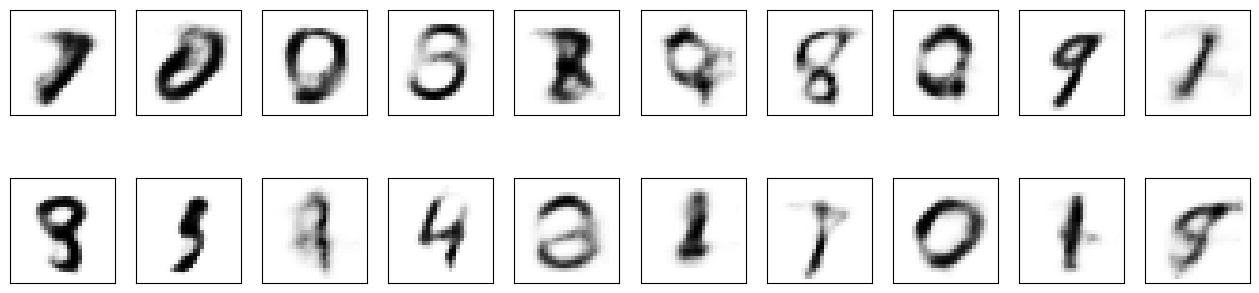

In [11]:
def plot_sample_images(images):
    plt.figure(figsize=(16, 4))
    for i, image in enumerate(images):
        plt.subplot(2, 10, i + 1)
        plt.imshow(image, cmap="binary")
        plt.xticks([])
        plt.yticks([])

    plt.show()

codings_size = 16
codings = torch.randn(size=(20, codings_size))
fake_images = torch.permute(vae.decoder(codings).detach(), [0, 2, 3, 1])
plot_sample_images(fake_images)

Some of the generated images may be difficult to read, but they all resemble handwritten digits. Considering it's a small model with only 10 epochs of training, the results are not bad. Feel free to experiment with the model to potentially achieve better results.

## Generative Adversarial Networks (GANs)
Generative Adversarial Networks (GANs) are another generative model we can use to generate, say, new images. Proposed by Ian Goodfellow and his colleagues in 2014, they work by pitting two neural networks against each other in a kind of minimax game. As you can see from the figure below, a GAN consists of two networks:

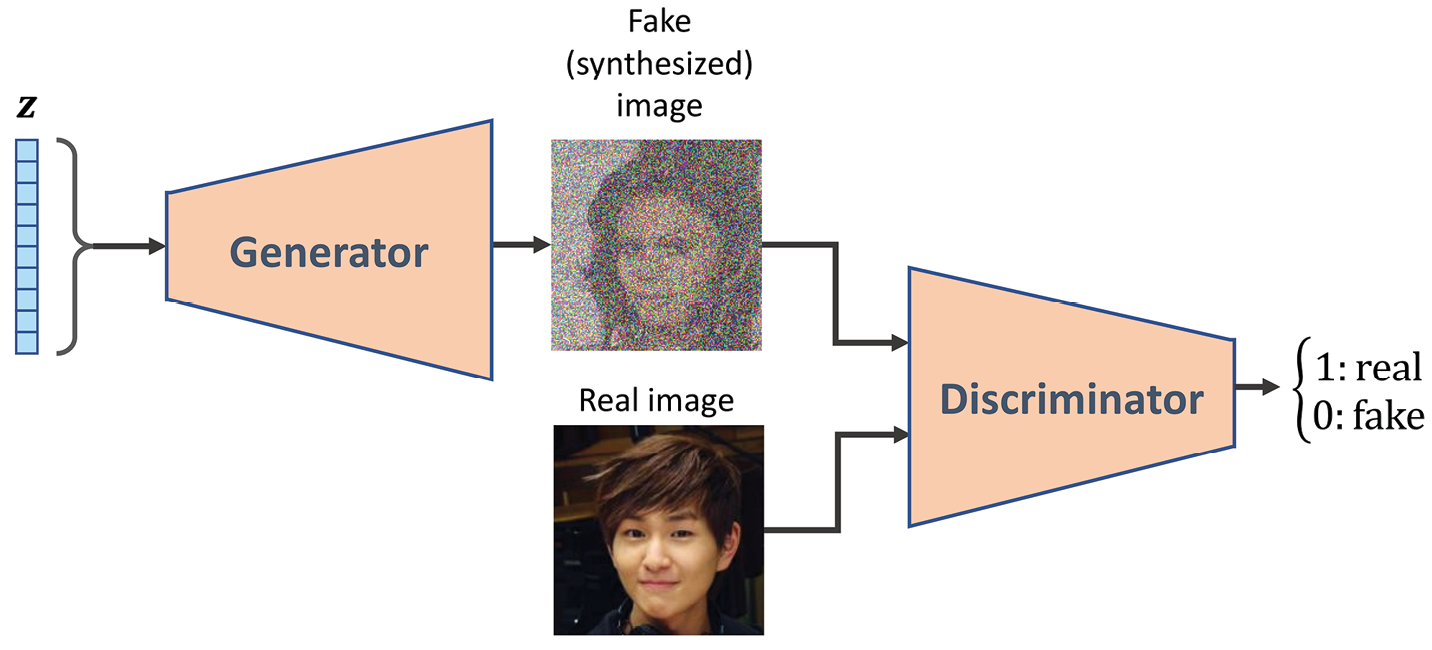

* **The Generator Network G**:It takes random noise as input and generates data (e.g., images) from that noise. Initially, the generator produces random, meaningless outputs.

* **Discriminator Network D**: It receives both real data samples from the training dataset and fake samples from the generator. Its job is to distinguish between real data and data generated by the generator. Initially, the discriminator's job is to randomly guess whether the input is real or fake.

During training, the generator and discriminator networks play a minimax game. The generator tries to improve its ability to generate realistic samples by receiving feedback from the discriminator, while the discriminator aims to correctly classify real and fake samples.

The generator generates fake samples and presents them to the discriminator along with real samples. The discriminator then tries to correctly classify whether each sample is real or fake. The feedback from the discriminator helps the generator adjust its parameters to produce more realistic data samples.

Meanwhile, the discriminator also adjusts its parameters to better distinguish between real and fake samples.

Both G and D networks are trained simultaneously in a competitive manner. As a result, building and training GANs is a complex task. Due to their volatile nature, they require a different approach to training than traditional models. Let's get started.

### A simple DCGAN Network: Generating Handwritt
Below is a simple DCGAN (Deep Convolutional GAN) network. DCGANs were the first successful deep convolutional GANs. They necessitate specific design choices, including:

- Avoiding pooling layers
- Incorporating batch normalization
- Utilizing ReLU activation in all generator (G) layers except the output layer, which should use tanh.
- Employing leaky ReLU in all discriminator (D) layers except the output layer, which should use sigmoid.

First, we define the size of the coding (latent vector) and the expected size of the image.

In [12]:
codings_size = 100
image_size = (28, 28)

Next, we create the two primary components of this network. The generator, which look like this:

In [13]:
g = nn.Sequential(
    nn.ConvTranspose2d(100, 128, 4, 1, 0, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(),

    nn.ConvTranspose2d(128, 64, 3, 2, 1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(),

    nn.ConvTranspose2d(64, 32, 4, 2, 1, bias=False),
    nn.BatchNorm2d(32),
    nn.ReLU(),

    nn.ConvTranspose2d(32, 1, 4, 2, 1, bias=False),
    nn.Tanh()
)

summary(g, input_size=(64, codings_size, 1, 1), device="cpu")

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [64, 1, 28, 28]           --
├─ConvTranspose2d: 1-1                   [64, 128, 4, 4]           204,800
├─BatchNorm2d: 1-2                       [64, 128, 4, 4]           256
├─ReLU: 1-3                              [64, 128, 4, 4]           --
├─ConvTranspose2d: 1-4                   [64, 64, 7, 7]            73,728
├─BatchNorm2d: 1-5                       [64, 64, 7, 7]            128
├─ReLU: 1-6                              [64, 64, 7, 7]            --
├─ConvTranspose2d: 1-7                   [64, 32, 14, 14]          32,768
├─BatchNorm2d: 1-8                       [64, 32, 14, 14]          64
├─ReLU: 1-9                              [64, 32, 14, 14]          --
├─ConvTranspose2d: 1-10                  [64, 1, 28, 28]           512
├─Tanh: 1-11                             [64, 1, 28, 28]           --
Total params: 312,256
Trainable params: 312,256
Non-trainable params:

Notice the use of transposed convolutions, making it a fully convolutional network. And then, there is the discriminator, which is also fully convolutional.

In [14]:
d = nn.Sequential(
    nn.Conv2d(1, 32, 4, 2, 1, bias=False),
    nn.LeakyReLU(0.2),

    nn.Conv2d(32, 64, 4, 2, 1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2),

    nn.Conv2d(64, 128, 3, 2, 1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2),

    nn.Conv2d(128, 1, 4, 1, 0, bias=False),
    nn.Flatten(),
    nn.Sigmoid()
)

summary(d, input_size=(64, 1, 28, 28), device="cpu")

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [64, 1]                   --
├─Conv2d: 1-1                            [64, 32, 14, 14]          512
├─LeakyReLU: 1-2                         [64, 32, 14, 14]          --
├─Conv2d: 1-3                            [64, 64, 7, 7]            32,768
├─BatchNorm2d: 1-4                       [64, 64, 7, 7]            128
├─LeakyReLU: 1-5                         [64, 64, 7, 7]            --
├─Conv2d: 1-6                            [64, 128, 4, 4]           73,728
├─BatchNorm2d: 1-7                       [64, 128, 4, 4]           256
├─LeakyReLU: 1-8                         [64, 128, 4, 4]           --
├─Conv2d: 1-9                            [64, 1, 1, 1]             2,048
├─Flatten: 1-10                          [64, 1]                   --
├─Sigmoid: 1-11                          [64, 1]                   --
Total params: 109,440
Trainable params: 109,440
Non-trainable params: 0

We are going to train these two component networks separately and together simultaneously. To accomplish this, we require two optimizers: one for the generator and another for the discriminator. For both, the loss can simply be the binary cross-entropy loss.

In [15]:
loss_fn = nn.BCELoss()
g_optimizer = torch.optim.Adam(g.parameters())
d_optimizer = torch.optim.Adam(d.parameters())

For training, there will be two training steps: one for the generator and another for the discriminator.

In [16]:
# Training the generator
def g_training_step(d, g, optimizer, x_batch):
    batch_size = x_batch.size(0)

    z = torch.randn(batch_size, codings_size, 1, 1)

    pred_fake = d(g(z))
    loss = loss_fn(pred_fake, torch.ones(batch_size, 1)) # Trying to fool the discriminator
                                                         # by passing the fake data as real.

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss.item()

# Training the discriminator
def d_training_step(d, g, optimizer, x_batch):
    batch_size = x_batch.size(0)

    # Train discriminator on a real batch
    pred_real = d(x_batch)
    loss_real = loss_fn(pred_real, torch.ones(batch_size, 1))

    # Train discriminator on a fake batch
    z = torch.randn(batch_size, codings_size, 1, 1)

    pred_fake = d(g(z))
    loss_fake = loss_fn(pred_fake, torch.zeros(batch_size, 1))

    # Total loss
    loss = loss_real + loss_fake

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss.item()

We are now ready to train this network and write the training loop. We will do so in a way that creates and saves sample generated images after every epoch. That way, we can observe how the quality of the generated images improves with training.

In [17]:
def create_samples(g, z):
    g_output = g(z)
    images = torch.reshape(g_output, (batch_size, *image_size))
    return (images + 1 ) / 2.0

batch_size = 32

z = torch.randn(batch_size, codings_size, 1, 1)

epoch_samples = []

all_d_losses = []
all_g_losses = []

epochs = 20
for epoch in range( epochs):
    d_losses, g_losses = [], []

    for x_batch, _ in dl_train:
        d_losses.append(d_training_step(d, g, d_optimizer, x_batch))
        g_losses.append(g_training_step(d, g, g_optimizer, x_batch))

    all_d_losses.append(torch.tensor(d_losses).mean())
    all_g_losses.append(torch.tensor(g_losses).mean())

    print(f"Epoch{epoch + 1: 3d}/{epochs}: g_loss={all_g_losses[-1]:.4f}, d_loss={all_d_losses[-1]:.4f}")
    epoch_samples.append(create_samples(g, z).detach().numpy())

Epoch  1/20: g_loss=7.7573, d_loss=0.0344
Epoch  2/20: g_loss=8.4803, d_loss=0.0294
Epoch  3/20: g_loss=8.5298, d_loss=0.0343
Epoch  4/20: g_loss=8.6726, d_loss=0.0151
Epoch  5/20: g_loss=9.2581, d_loss=0.0315
Epoch  6/20: g_loss=8.9763, d_loss=0.0177
Epoch  7/20: g_loss=10.2504, d_loss=0.0134
Epoch  8/20: g_loss=10.8000, d_loss=0.0126
Epoch  9/20: g_loss=11.4564, d_loss=0.0022
Epoch 10/20: g_loss=12.9516, d_loss=0.0068
Epoch 11/20: g_loss=12.1613, d_loss=0.0063
Epoch 12/20: g_loss=13.1001, d_loss=0.0049
Epoch 13/20: g_loss=16.1895, d_loss=0.0100
Epoch 14/20: g_loss=11.1749, d_loss=0.0030
Epoch 15/20: g_loss=13.4347, d_loss=0.0029
Epoch 16/20: g_loss=14.5454, d_loss=0.0036
Epoch 17/20: g_loss=13.4978, d_loss=0.0019
Epoch 18/20: g_loss=16.6067, d_loss=0.0026
Epoch 19/20: g_loss=20.2770, d_loss=0.0018
Epoch 20/20: g_loss=49.3921, d_loss=0.0011


Notice how simple the training loop is. It only consists of two steps per batch: the discriminator training step and the generator training step. Below are the learning curves for both the generator and discriminator:

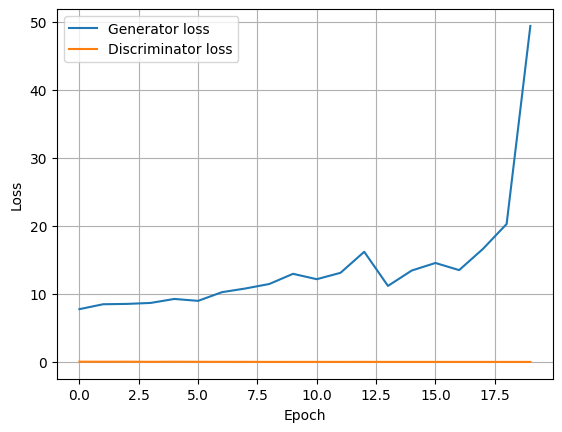

In [18]:
plt.plot(all_g_losses, label='Generator loss')
plt.plot(all_d_losses, label='Discriminator loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

To see the progress of training, let's plot some sample generated images after various selected training epochs:

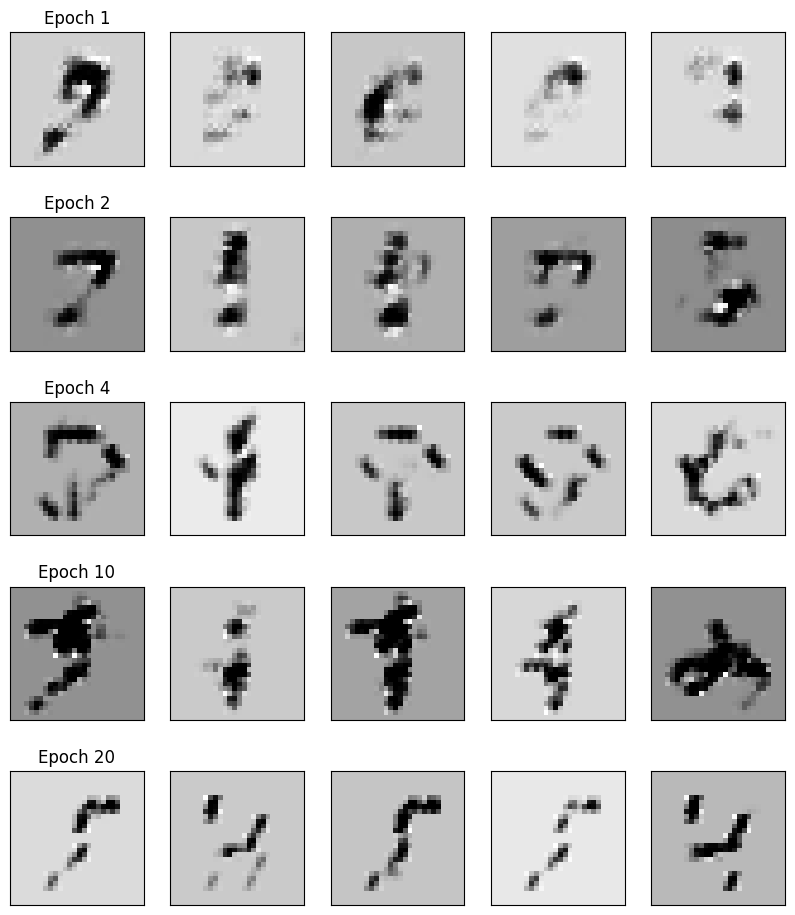

In [19]:
selected_epochs = [1, 2, 4, 10, 20]
fig = plt.figure(figsize=(10, 14))
for i,e in enumerate(selected_epochs):
    for j in range(5):
        plt.subplot(6, 5, i*5+j+1)
        plt.xticks([])
        plt.yticks([])
        if j == 0:
            plt.title( f'Epoch {e}')
        image = np.clip(epoch_samples[e-1][j], 0, 1)
        plt.imshow(image, cmap='binary')

plt.show()

As you can see, the quality of the generated images increases with epochs.

Finally, let's use the trained generator to generate and plot new images. As you can see below, the input to the generator is simply a batch of random tensors sampled from the standard normal distribution with a mean of 0 and a standard deviation of 1.

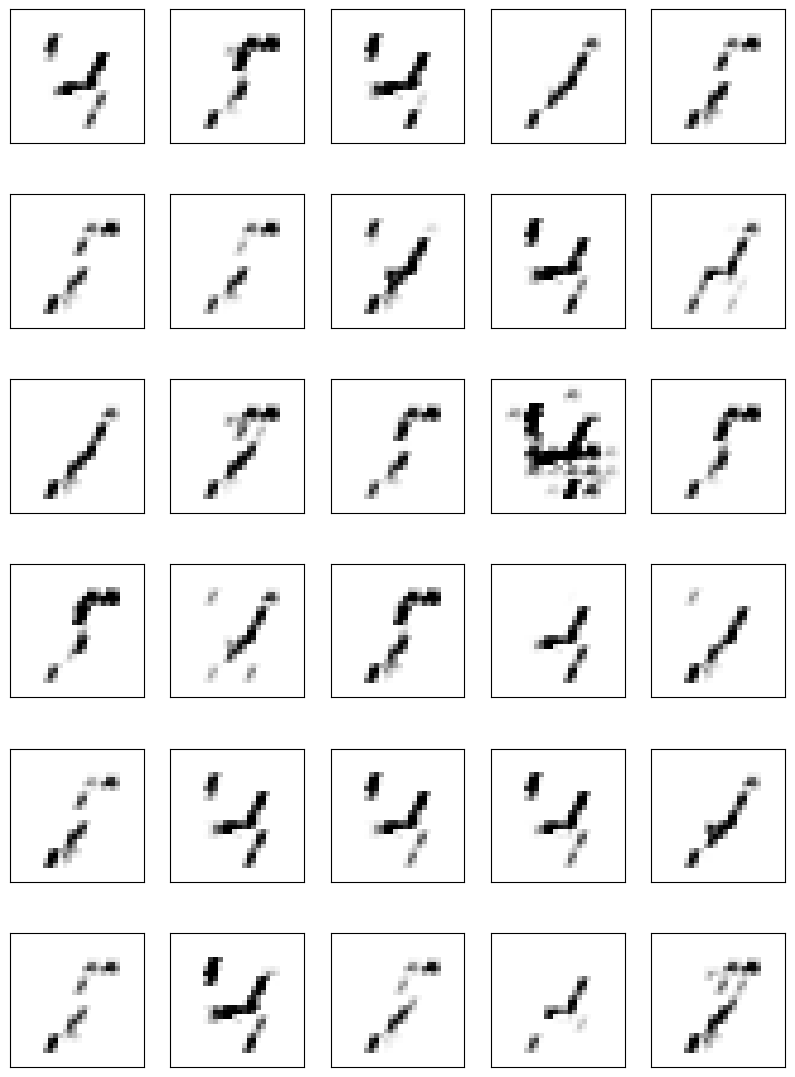

In [20]:
z = torch.randn(batch_size, codings_size, 1, 1)

images = np.clip(g(z).detach().permute(0, 2, 3, 1), 0, 1)
fig = plt.figure(figsize=(10, 14))
for i in range(30):
    plt.subplot(6, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(images[i], cmap='binary')

### Another DCGAN Example: Generating Butterflies

In [21]:
import os
import opendatasets as od
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
from torchvision.utils import make_grid
import lightning as L
from collections import OrderedDict

Let's have another, more interesting example. Let's build and train a DCGAN to generate images of butterflies.

First, download the data from Kaggle. To do this, ensure that you have a valid Kaggle account with a verified phone number. Then, navigate to your account settings by clicking on the avatar icon located in the top right corner. From there, select your profile and go to the Account tab. In the API section, click on the 'Create New Token' button. This action will initiate the download of a 'kaggle.json' file. Remember to save this file as it contains both your username and your API key. You will need to enter both when prompted upon running the following cell.

In [22]:
dataset_url =  "https://www.kaggle.com/gpiosenka/butterfly-images40-species"
od.download(dataset_url, data_dir='./datasets')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: aalgahmi4dl
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/gpiosenka/butterfly-images40-species


Next, we set a few variables, including the `latent_size` (aka. codings size), and some values for normalizing the images.

In [23]:
image_size = 64
batch_size = 128
normalize = [(0.5, 0.5, 0.5), (0.5, 0.5, 0.5)]
latent_size = 256

data_path = "./datasets/butterfly-images40-species/train"

We can use `torchvision.datasets.ImageFolder` to read the downloaded training images into a training dataset. To expedite training, let's utilize only 60% of the images.

In [24]:
ds_train, _ = random_split(
    ImageFolder(data_path, transform=T.Compose([
        T.Resize(image_size),
        T.CenterCrop(image_size),
        T.ToTensor(),
        T.Normalize(*normalize)])
    ), [.6, .4])

dl_train = DataLoader(ds_train, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
len(dl_train)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


60

Below, we'll need the capability to display sample images, both real and fake. Here's a function that utilizes `torchvision.utils.make_grid` to create an 8 by 8 grid of images. Because the images were normalized when we created the dataset, we have to de-normalize them before showing them.

In [25]:
from torchvision.utils import make_grid

def show_sample_images(images, n_images = 64, title="Sample images"):
    fig, ax = plt.subplots(figsize=(8, 8))

    images= images.detach()[:n_images]
    denormalized_images = images * .5 + .5

    ax.imshow(make_grid(denormalized_images, nrow=8).permute(1, 2, 0))

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(title)

    plt.show()

Below are sample training images arranged in an 8 by 8 grid, generated using the function described above.

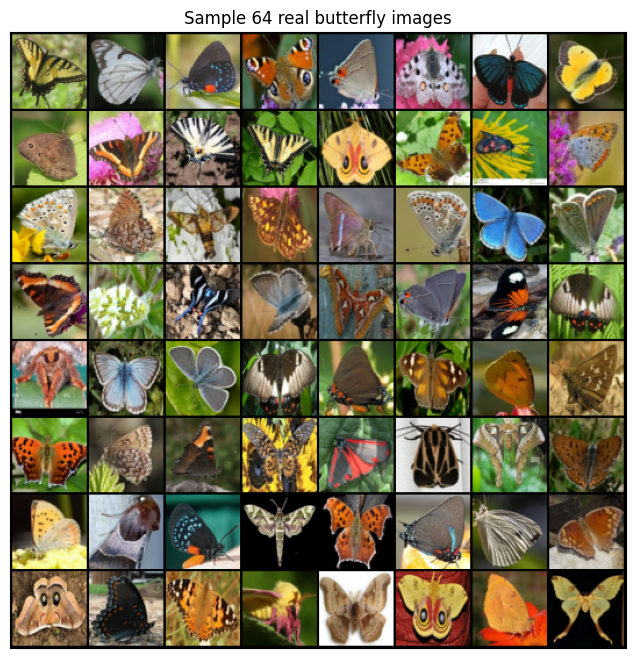

In [26]:
for images, _ in dl_train:
  show_sample_images(images, title="Sample 64 real butterfly images")
  break

Next, we will build a GAN network using Lightning. However, we need to handle this in a special way due to having two optimizers instead of just one. And Lightning supports multiple optimizers, but it requires using manual optimization instead of the automatic optimization mode we are accustomed to.

To achieve this, we set:
```python
    self.automatic_optimization = False
```

in the `__init__` method. The optimizers are then defined and returned inside the `configure_optimizers(self)` method. Within the training step, we retrieve the configured optimizers like this:

```python
    g_opt, d_opt = self.optimizers()
```

The training step then proceeds as in the example above. One thing to keep in mind here is that because we are using manual optimization, we need to zero out the gradients, call the backward function on the losses, and instruct the optimizers to update their respective weights. Under automatic optimization, Lightning handles this for us, but with manual optimization, we need to manage it ourselves. Here is how that is done:

```python
    g_opt.zero_grad()
    self.manual_backward(g_loss)
    g_opt.step()
    
    ...
    
    d_opt.zero_grad()
    self.manual_backward(d_loss)
    d_opt.step()
```

Notice the use of Lightning's `manual_backward(loss)` function instead of the standard PyTorch `loss.backward()`. Lightning's manual optimization requires this. The rest is the same as before.

Here is the Lightning module with all these changes.

In [27]:
class ButterflyGAN(L.LightningModule):

    def __init__(self, latent_size = 256, batch_size = 128, learning_rate = 0.0002):#, bias1 = 0.5,bias2 = 0.999,):
        super().__init__()

        self.save_hyperparameters()

        self.g = nn.Sequential(
            nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),

            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )

        self.d = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(negative_slope = 0.2, inplace=True),

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(negative_slope = 0.2, inplace=True),

            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(negative_slope = 0.2, inplace=True),

            nn.Conv2d(512, 1024, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(negative_slope = 0.2, inplace=True),

            nn.Flatten(),
            nn.Linear(in_features=16384,out_features=1),
            nn.Sigmoid()
        )

        self.batch_size = batch_size
        self.latent_size = latent_size
        self.z = torch.randn(self.batch_size, self.latent_size, 1, 1)

        self.automatic_optimization = False

    def forward(self, z):
        return self.g(z)

    def configure_optimizers(self):
        lr = self.hparams.learning_rate

        g_optimizer = torch.optim.Adam(self.g.parameters(), lr=lr, betas=(0.5, 0.999))
        d_optimizer = torch.optim.Adam(self.d.parameters(), lr=lr, betas=(0.5, 0.999))

        return [g_optimizer, d_optimizer]

    def training_step(self, batch, batch_idx):
        g_opt, d_opt = self.optimizers()

        real_images, _ = batch

        # Training the generator
        z = torch.randn(self.batch_size, self.latent_size, 1, 1).type_as(real_images)
        fake_images = self.g(z)

        g_loss = F.binary_cross_entropy(
            self.d(fake_images),
            torch.ones(self.batch_size, 1).type_as(real_images) # Try to fool the
        )                                                       # discriminator

        g_opt.zero_grad()
        self.manual_backward(g_loss)
        g_opt.step()

        self.log('g_loss', g_loss, prog_bar=True)

        # Training the discriminator
        real_loss = F.binary_cross_entropy(
            self.d(real_images),
            torch.ones(real_images.size(0), 1).type_as(real_images)
        )

        z = torch.randn(self.batch_size, self.latent_size, 1, 1).type_as(real_images)
        fake_images = self.g(z)

        fake_loss = F.binary_cross_entropy(
            self.d(fake_images),
            torch.zeros(fake_images.size(0), 1).type_as(real_images)
        )

        self.log('discriminator_loss', fake_loss, prog_bar=True)

        # Combining the losses
        d_loss = real_loss + fake_loss

        d_opt.zero_grad()
        self.manual_backward(d_loss)
        d_opt.step()

        output = OrderedDict({ 'g_loss': g_loss, 'd_loss': d_loss })

        return output


Using this module, let's create a GAN and train it. We will do so for 100 epochs, but we'll break it down into 20-epoch batches so that we can inspect the generated images before proceeding to the next batch of epochs.

In [28]:
model = ButterflyGAN()

trainer = L.Trainer(max_epochs=20)
z = torch.randn(batch_size, latent_size, 1, 1)
sample_images = [(model(z), f"64 generated butterfly images before training")]
for i in range(1, 6):
    trainer = L.Trainer(max_epochs=20)
    trainer.fit(model, dl_train)

    z = torch.randn(batch_size, latent_size, 1, 1)
    sample_images.append((model(z), f"64 generated butterfly images after epoch {20 * i}"))


INFO: You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:lightning.pytorch.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:lightning.pytorch.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model r

Training: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=20` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.
INFO: You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:lightning.pytorch.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name | Type       |

Training: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=20` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.
INFO: You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:lightning.pytorch.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name | Type       |

Training: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=20` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.
INFO: You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:lightning.pytorch.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name | Type       |

Training: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=20` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.
INFO: You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:lightning.pytorch.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name | Type       |

Training: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=20` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


Here are the results:

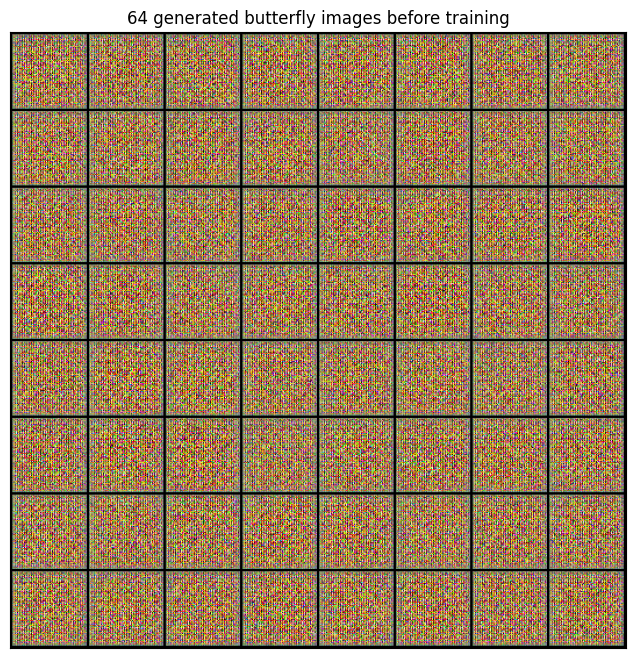

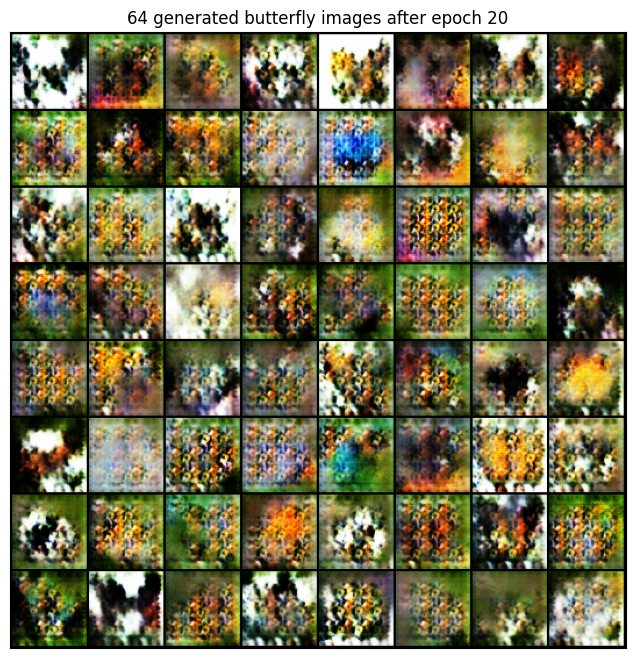

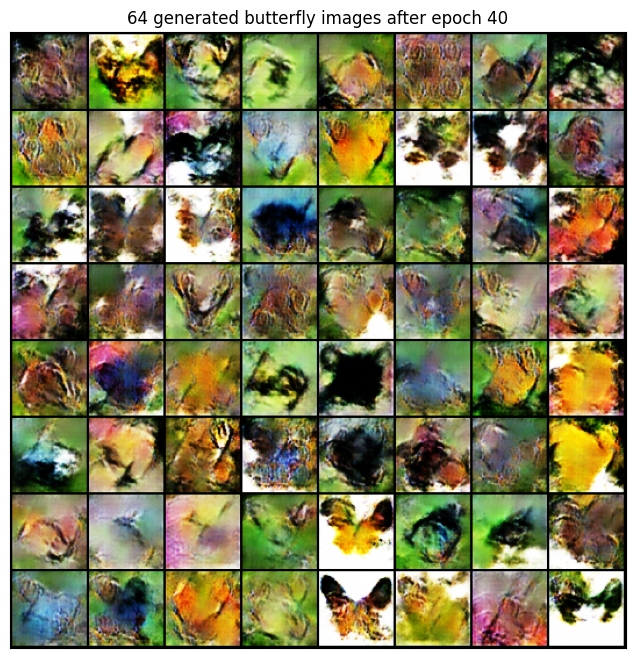

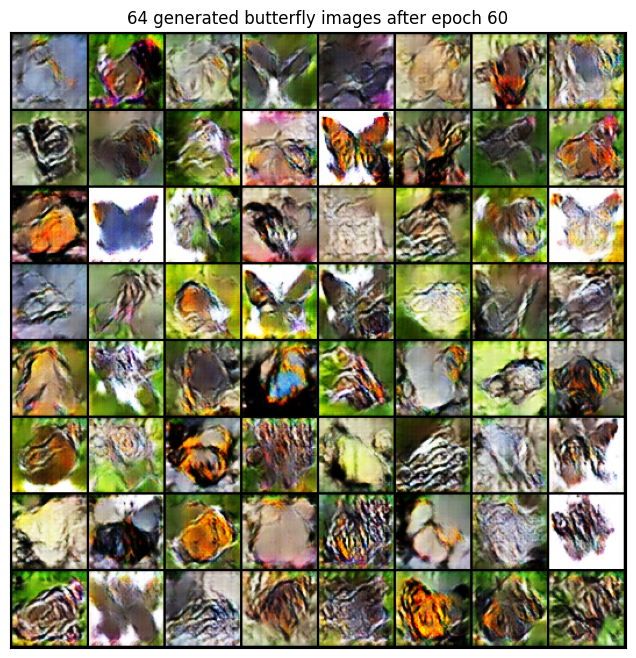

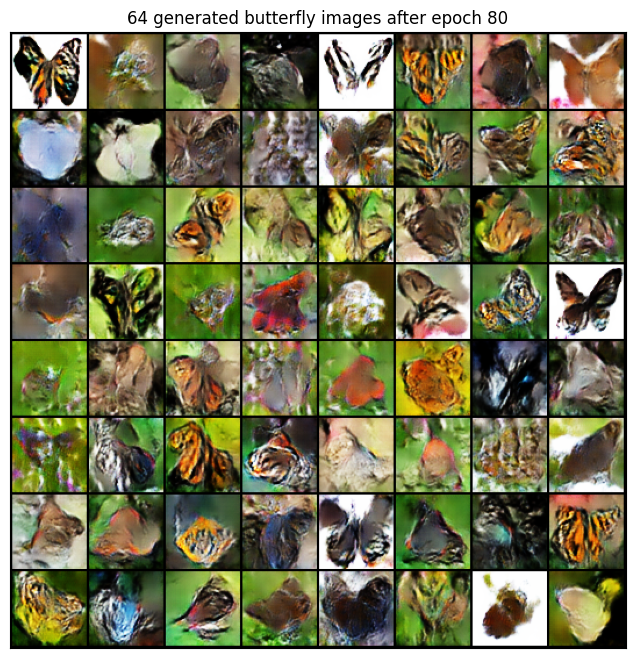

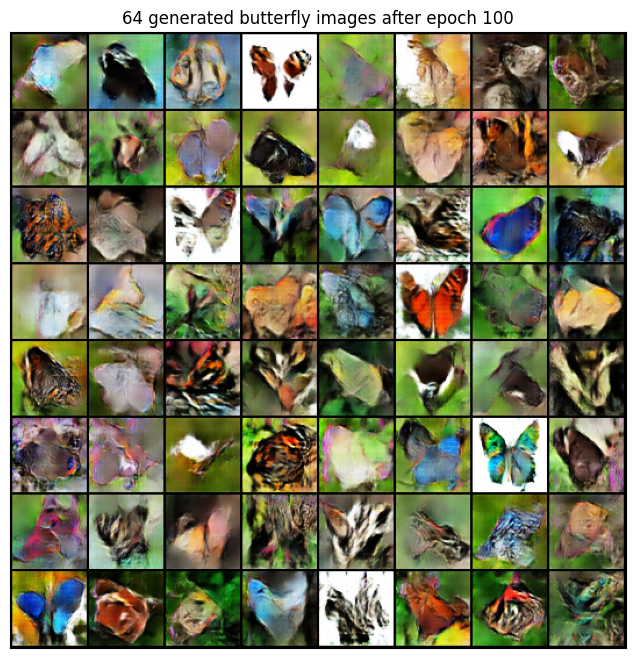

In [29]:
for i, (images, title) in enumerate(sample_images):
    show_sample_images(images, title=title)

Notice how the quality of the generated images greatly improved with more epochs. In the beginning there was only noise, but that changed progressively as training continued.

Happy learning!